In [116]:
from langgraph.graph import StateGraph, START,END
from langchain_groq import ChatGroq
from typing import Dict, List, Optional,TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
import re 
import json
import pandas as pd

In [117]:
load_dotenv()

True

In [118]:
llm=ChatGroq(model='gemma2-9b-it')

In [ ]:
class AgentState(TypedDict):
    patient_name: str = ""
    first_patient_name: str = ""
    last_patient_name: str = ""
    date_of_birth: str = ""
    doctor: str = ""
    location: str = ""
    patient_type: str = Literal['new','existing']
    appointment_duration: Literal['30 minutes','60 minutes']
    selected_time_start: str=''
    selected_time_end: str=''
    selected_time_date: str=''
    selected_slot: Optional[Dict] = None
    insurance_carrier: str = ""
    insurance_member_id: str = ""
    insurance_group: str = ""
    patient_email: str = ""
    patient_contact: str = ""
    # current_step: str = ""
    # conversation_history: List[str] = field(default_factory=list)
    appointment_confirmed: bool = False
    patient_id: Optional[int] = None
    appointment_id: Optional[str] = None
    message: str = ""
    response: str = ""
    available_slots: List[Dict]
    user_input: bool = False 

In [120]:
def clean_llm_response(text: str):
    """Clean and parse LLM response to extract JSON"""
      
    text = text.strip()
    
    # Remove markdown code blocks
    if "```json" in text:
        text = text.split("```json")[1].split("```")[0]
    elif "```" in text:
        text = text.split("```")[1].split("```")[0]
    
    # Find JSON object
    json_match = re.search(r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}', text, re.DOTALL)
    if json_match:
        json_str = json_match.group(0)
        # Fix common JSON issues
        json_str = re.sub(r"'", '"', json_str)  # Replace single quotes
        json_str = re.sub(r'(\w+):', r'"\1":', json_str)  # Add quotes to keys
        
        parsed = json.loads(json_str)
        return {k: "" if v is None else str(v) for k, v in parsed.items()}
    
    return None

In [121]:
def greeting(state: AgentState):
    # Collect name, DOB, doctor, location
    print("Hello! Please provide your full name, date of birth, preferred doctor, and location.")
    message=input("User: ")
    extract_info_prompt = PromptTemplate(
            input_variables=["message"],
            template="""
            Extract the following information from the user's message if available:
            1. Full Name
            2. Date of Birth (YYYY-MM-DD format)
            3. Preferred Doctor (Dr. Name)
            4. Location
            If any information is missing, return "Not Provided" for that field.
            User Message: {message}
            Provide the extracted information in the following JSON format:
            {{
                "Full Name": "<extracted_name_or_Not Provided>",
                "Date of Birth": "<extracted_dob_or_Not Provided>",
                "Preferred Doctor": "<extracted_doctor_or_Not Provided>",
                "Location": "<extracted_location_or_Not Provided>"
            }}
            Ensure the JSON is properly formatted.
            
            JSON:"""
            )
    chain = extract_info_prompt | llm
    response = chain.invoke({"message": message})
    extracted_text = response.content if hasattr(response, 'content') else response.text
    clean_text=clean_llm_response(extracted_text)
    full_name=clean_text.get("Full Name","Not Provided")
    dob=clean_text.get("Date of Birth","Not Provided")
    doctor=clean_text.get("Preferred Doctor","Not Provided")
    location=clean_text.get("Location","Not Provided")
    return {
        "patient_name": full_name,
        "date_of_birth": dob,
        "doctor": doctor,
        "location": location}

In [8]:
greeting({})

Hello! Please provide your full name, date of birth, preferred doctor, and location.


{'patient_name': 'palak',
 'date_of_birth': 'Not Provided',
 'doctor': 'Not Provided',
 'location': 'Not Provided'}

In [9]:
!pip install faker

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
from synthetic_data_generation import DataGenerator

data_generator = DataGenerator()
data_generator.generate_synthetic_data()


ImportError: cannot import name 'DataGenerator' from 'synthetic_data_generation' (d:\Raga-Assignment\synthetic_data_generation.py)

In [122]:
def lookup(state: AgentState):
    # Lookup patient in database
    print(f"Looking up patient {state['patient_name']} with DOB {state['date_of_birth']}...")
    file_path= "data/patients.csv"
    if not state['patient_name'] or not state['date_of_birth']:
        print("Insufficient information to lookup patient.")
        return {"patient_id": None}
    if state['patient_name']=="Not Provided" or state['date_of_birth']=="Not Provided":
        print("Insufficient information to lookup patient.")
        return {"patient_id": None}
    if not re.match(r'\d{4}-\d{2}-\d{2}', state['date_of_birth']):
        print("Date of Birth format is incorrect. Please use YYYY-MM-DD format.")
        return {"patient_id": None}
    df = pd.read_csv(file_path)
    match = df[
        (df['full_name'].str.lower() == state['patient_name'].lower()) & 
        (df['date_of_birth'] == state['date_of_birth'])
    ]
    if not match.empty:
        patient_id = match.iloc[0]['id']
        patient_contact = match.iloc[0]['phone']
        patient_email = match.iloc[0]['email']
        insurance_carrier=match.iloc[0]['insurance_carrier']
        insurance_member_id=match.iloc[0]['insurance_member_id']
        insurance_group=match.iloc[0]['insurance_group']
        print(f"Patient found with ID: {patient_id}")
        return {"patient_id": int(patient_id),
                "patient_type":"existing",
                "appointment_duration":"30 minutes",
                "insurance_carrier":insurance_carrier,
                'insurance_member_id':insurance_member_id,
                'insurance_group':insurance_group,
                "patient_contact":patient_contact,
                "patient_email":patient_email}
    else:
        print("No matching patient found. Proceeding as new patient.")
        return {"patient_id": None,
                "patient_type":"new",
                "appointment_duration":"60 minutes"}
 
    

In [123]:
lookup({"patient_name": "Nicole Lopez", "date_of_birth": "1999-11-19"})

Looking up patient Nicole Lopez with DOB 1999-11-19...
Patient found with ID: 1


{'patient_id': 1,
 'patient_type': 'existing',
 'appointment_duration': '30 minutes',
 'insurance_carrier': 'Blue Cross',
 'insurance_member_id': 'yO068168',
 'insurance_group': 'GRP746',
 'patient_contact': '776.385.9902x9138',
 'patient_email': 'zacharysanders@example.com'}

In [124]:
from datetime import datetime, timedelta

In [125]:
def get_available_slots(dataset_path: str, duration: int, doctor_name: str, location: str):
    try:
        # Load schedule
        df = pd.read_excel(dataset_path)

        # Normalize doctor + location input
        doctor_name = doctor_name.strip()
        location = location.strip()

        # Ensure datetime parsing
        df["start_time"] = pd.to_datetime(df["start_time"], format="%H:%M").dt.time
        df["end_time"] = pd.to_datetime(df["end_time"], format="%H:%M").dt.time

        # Force date column to datetime.date
        df["date"] = pd.to_datetime(df["date"]).dt.date

        # Filter for doctor/location/availability
        df = df[
            (df["doctor_name"].str.strip() == doctor_name) &
            (df["location"].str.strip() == location) &
            (df["available"] == True)
        ].copy()
        if df.empty:
            return []

        # Convert to datetime objects (merge with date column)
        df["start_dt"] = df.apply(lambda r: datetime.combine(r["date"], r["start_time"]), axis=1)
        df["end_dt"] = df.apply(lambda r: datetime.combine(r["date"], r["end_time"]), axis=1)

        available_slots = []

        if duration == 30:
            for _, row in df.iterrows():
                slot_duration = row["end_dt"] - row["start_dt"]
                available_slots.append({
                    "date": row["date"],
                    "start_time": row["start_time"].strftime("%H:%M"),
                    "end_time": row["end_time"].strftime("%H:%M"),
                    "location": row["location"],
                    "duration": str(slot_duration)
                })
                
        elif duration == 60:
            df_sorted = df.sort_values(["date", "start_dt"]).reset_index(drop=True)
            for i in range(len(df_sorted) - 1):
                row1, row2 = df_sorted.iloc[i], df_sorted.iloc[i+1]
                if (
                    row1["end_dt"] == row2["start_dt"] and
                    row1["date"] == row2["date"] and
                    row1["location"] == row2["location"]
                ):
                    slot_duration = row2["end_dt"] - row1["start_dt"]
                    available_slots.append({
                        "date": row1["date"].strftime("%Y-%m-%d"),
                        "start_time": row1["start_time"].strftime("%H:%M"),
                        "end_time": row2["end_time"].strftime("%H:%M"),
                        "location": row1["location"],
                        "duration": str(slot_duration)
                    })

        return available_slots

    except Exception as e:
        print(f"Error fetching slots: {e}")
        return []


In [58]:
available_slots = get_available_slots("data/doctor_schedules.xlsx", 60, "Dr. Smith", "Downtown Office")
available_slots

[{'date': '2025-09-05',
  'start_time': '09:00',
  'end_time': '10:00',
  'location': 'Downtown Office',
  'duration': '0 days 01:00:00'},
 {'date': '2025-09-05',
  'start_time': '09:30',
  'end_time': '10:30',
  'location': 'Downtown Office',
  'duration': '0 days 01:00:00'},
 {'date': '2025-09-05',
  'start_time': '10:00',
  'end_time': '11:00',
  'location': 'Downtown Office',
  'duration': '0 days 01:00:00'},
 {'date': '2025-09-05',
  'start_time': '14:00',
  'end_time': '15:00',
  'location': 'Downtown Office',
  'duration': '0 days 01:00:00'},
 {'date': '2025-09-08',
  'start_time': '09:30',
  'end_time': '10:30',
  'location': 'Downtown Office',
  'duration': '0 days 01:00:00'},
 {'date': '2025-09-08',
  'start_time': '10:00',
  'end_time': '11:00',
  'location': 'Downtown Office',
  'duration': '0 days 01:00:00'},
 {'date': '2025-09-08',
  'start_time': '10:30',
  'end_time': '11:30',
  'location': 'Downtown Office',
  'duration': '0 days 01:00:00'},
 {'date': '2025-09-08',
  '

In [126]:
file_path="data/doctor_schedules.xlsx"
df=pd.read_excel(file_path)
if ('Dr. Smith' in df['doctor_name'].values):
    print(f"Doctor not found in the schedule database.")
      

Doctor not found in the schedule database.


In [127]:
def scheduling_new(state: AgentState):
    file_path="data/doctor_schedules.xlsx"
    print('No data fount in records, time duration for new patient: 60 minutes')
    df=pd.read_excel(file_path)
    if not state['doctor'] or state['doctor']=="Not Provided":
        print("Doctor name not provided. Cannot schedule appointment.")
        return {"available_slots":[]}
    if (state['doctor'] not in df['doctor_name'].values):
        print(f"Doctor {state['doctor']} not found in the schedule database.")
        print(f"Available doctors: {df['doctor_name'].unique()}")
        return {"available_slots":[]}
    if not state['location'] or state['location']=="Not Provided":
        print("Location not provided. Cannot schedule appointment.")
        print(f"Available locations for {state['doctor']}: {df[df['doctor_name']==state['doctor']]['location'].unique()}")
        return {"available_slots":[]}
    if (state['location'] not in df[df['doctor_name']==state['doctor']]['location'].values):
        print(f"Location {state['location']} not found for doctor {state['doctor']}.")
        print(f"Available locations for {state['doctor']}: {df[df['doctor_name']==state['doctor']]['location'].unique()}")
        return {"available_slots":[]}
    if state['appointment_duration']=="60 minutes":
        available_slots= get_available_slots("data/doctor_schedules.xlsx", 60, state['doctor'], state['location'])
    if available_slots:
        print(f"Found {len(available_slots)} available slots for {state['doctor']} at {state['location']}.")
        print("Available slots:")
        length=len(available_slots)
        for slot in range(1,len(available_slots)):
            print(f"{slot}. Date: {available_slots[slot]['date']}, Time: {available_slots[slot]['start_time']} - {available_slots[slot]['end_time']}")
        
        user_input=int(input(f'Select from 1-{length}'))
        if user_input in range(1,len(available_slots)):
            selected_time_start= available_slots[user_input]['start_time']
            selected_time_end= available_slots[user_input]['end_time']
            selected_time_date=available_slots[user_input]['date']
           
            print(f'The selected slot for {state['doctor']} at {state['location']} is {selected_time_start}- {selected_time_end} on {selected_time_date} ')
          
            
            return {
                'selected_time_end':selected_time_end,
                'selected_time_start':selected_time_start,
                'selected_time_date':selected_time_date,
            }
            
        else:
            print(f'Please select from this range only (0-{len(available_slots)}) ')
    else:
        print(f"No available slots found for {state['doctor']} at {state['location']}.")

    

In [128]:
ans=scheduling_new({"doctor": "Dr. Smith", "location": "Main Clinic", "appointment_duration": "60 minutes"})
ans

No data fount in records, time duration for new patient: 60 minutes
Found 77 available slots for Dr. Smith at Main Clinic.
Available slots:
1. Date: 2025-09-05, Time: 09:30 - 10:30
2. Date: 2025-09-05, Time: 10:00 - 11:00
3. Date: 2025-09-05, Time: 10:30 - 11:30
4. Date: 2025-09-05, Time: 11:00 - 12:00
5. Date: 2025-09-05, Time: 16:00 - 17:00
6. Date: 2025-09-08, Time: 10:30 - 11:30
7. Date: 2025-09-08, Time: 11:00 - 12:00
8. Date: 2025-09-09, Time: 09:00 - 10:00
9. Date: 2025-09-09, Time: 09:30 - 10:30
10. Date: 2025-09-09, Time: 10:00 - 11:00
11. Date: 2025-09-09, Time: 10:30 - 11:30
12. Date: 2025-09-09, Time: 11:00 - 12:00
13. Date: 2025-09-09, Time: 15:30 - 16:30
14. Date: 2025-09-09, Time: 16:00 - 17:00
15. Date: 2025-09-10, Time: 10:00 - 11:00
16. Date: 2025-09-10, Time: 15:00 - 16:00
17. Date: 2025-09-10, Time: 15:30 - 16:30
18. Date: 2025-09-11, Time: 09:30 - 10:30
19. Date: 2025-09-11, Time: 10:00 - 11:00
20. Date: 2025-09-11, Time: 10:30 - 11:30
21. Date: 2025-09-11, Time: 1

{'selected_time_end': '11:30',
 'selected_time_start': '10:30',
 'selected_time_date': '2025-09-24'}

In [129]:
def scheduling_returning(state: AgentState):
    file_path="data/doctor_schedules.xlsx"
    print('Records Found In Dataset, TIme duration for existing patient: 30 minutes')
    df=pd.read_excel(file_path)
    if not state['doctor'] or state['doctor']=="Not Provided":
        print("Doctor name not provided. Cannot schedule appointment.")
        return {"available_slots":[]}
    if (state['doctor'] not in df['doctor_name'].values):
        print(f"Doctor {state['doctor']} not found in the schedule database.")
        print(f"Available doctors: {df['doctor_name'].unique()}")
        return {"available_slots":[]}
    if not state['location'] or state['location']=="Not Provided":
        print("Location not provided. Cannot schedule appointment.")
        print(f"Available locations for {state['doctor']}: {df[df['doctor_name']==state['doctor']]['location'].unique()}")
        return {"available_slots":[]}
    if (state['location'] not in df[df['doctor_name']==state['doctor']]['location'].values):
        print(f"Location {state['location']} not found for doctor {state['doctor']}.")
        print(f"Available locations for {state['doctor']}: {df[df['doctor_name']==state['doctor']]['location'].unique()}")
        return {"available_slots":[]}
    if state['appointment_duration']=="30 minutes":
        available_slots= get_available_slots("data/doctor_schedules.xlsx", 30, state['doctor'], state['location'])
    if available_slots:
        print(f"Found {len(available_slots)} available slots for {state['doctor']} at {state['location']}.")
        print("Available slots:")
        length=len(available_slots)
        for slot in range(1,len(available_slots)):
            print(f"{slot}. Date: {available_slots[slot]['date']}, Time: {available_slots[slot]['start_time']} - {available_slots[slot]['end_time']}")
        
        user_input=int(input(f'Select from 1-{length}'))
        if user_input in range(1,len(available_slots)):
            selected_time_start= available_slots[user_input]['start_time']
            selected_time_end= available_slots[user_input]['end_time']
            selected_time_date=available_slots[user_input]['date']
           
            print(f'The selected slot for {state['doctor']} at {state['location']} is {selected_time_start}- {selected_time_end} on {selected_time_date} ')
            return {
                'selected_time_end':selected_time_end,
                'selected_time_start':selected_time_start,
                'selected_time_date':selected_time_date
            }
    else:
        print(f"No available slots found for {state['doctor']} at {state['location']}.")

    

In [130]:
def insurance(state: AgentState):
    if state['patient_type']=='new':
        message=input(f'Please provide your Insurance Carrier, Member ID, Group')
        
        extract_info_prompt = PromptTemplate(
                input_variables=["message"],
                template="""
                Extract the following information from the user's message if available:
                1. Insurance Carrier
                2. Member ID
                3. Group
                If any information is missing, return "Not Provided" for that field.
                User Message: {message}
                Provide the extracted information in the following JSON format:
                {{
                    "Insurance Carrier": "<extracted_carrier_or_Not Provided>",
                    "Member ID": "<extracted_dob_or_Not Provided>",
                    "Group": "<extracted_doctor_or_Not Provided>",
                }}
                Ensure the JSON is properly formatted.
                
                JSON:"""
                )
        chain = extract_info_prompt | llm
        response = chain.invoke({"message": message})
        extracted_text = response.content if hasattr(response, 'content') else response.text
        clean_text=clean_llm_response(extracted_text)
        insurance_carrier=clean_text.get("Insurance Carrier","Not Provided")
        insurance_member_id=clean_text.get("Member ID","Not Provided")
        insurance_group=clean_text.get("Group","Not Provided")
        if insurance_carrier=='Not Provided':
            print('Please provide the carrier')
        if insurance_member_id=='Not Provided':
            print('Please provide the member id')
        if insurance_group=='Not Provided':
            print('Please provide the group')
        patient_contact=input('Please provide your contact number')
        if patient_contact is None:
            print('Please provide your contact number')
        patient_email=input('Please provide your email number')
        if patient_email is None:
            print('Please provide your email number')
        return {
            'insurance_carrier':insurance_carrier,
            'insurance_member_id':insurance_member_id,
            'insurance_group':insurance_group,
            'patient_contact':patient_contact,
            'patient_email':patient_email
        }
    

In [ ]:
insurance({'patient_type':'new'})

In [ ]:
  patient_name: str = ""
    first_patient_name: str = ""
    last_patient_name: str = ""
    date_of_birth: str = ""
    doctor: str = ""
    location: str = ""
    patient_type: str = Literal['new','existing']
    appointment_duration: Literal['30 minutes','60 minutes']
    selected_time_start: str=''
    selected_time_end: str=''
    selected_time_date: str=''
    selected_slot: Optional[Dict] = None
    insurance_carrier: str = ""
    insurance_member_id: str = ""
    insurance_group: str = ""
    patient_email: str = ""
    patient_contact: str = ""
    # current_step: str = ""
    # conversation_history: List[str] = field(default_factory=list)
    appointment_confirmed: bool = False
    # patient_id: Optional[int] = None
    appointment_id: Optional[str] = None
    message: str = ""
    response: str = ""
    available_slots: List[Dict]
    user_input: bool = False 

In [131]:
import pandas as pd
from datetime import datetime

def confirmation(state: AgentState):
    required_fields = [
        "patient_name",
        "date_of_birth",
        "doctor",
        "location",
        "selected_time_date",
        "selected_time_end",
        "selected_time_start",
        "insurance_carrier",
        "insurance_group",
        "insurance_member_id",
        "patient_email",
        "patient_contact"
    ]

    # Show details (with fallback)
    print(f'''Your details
    patient_name = {state.get('patient_name', 'Not provided')}
    date_of_birth = {state.get('date_of_birth', 'Not provided')}
    doctor = {state.get('doctor', 'Not provided')}
    location = {state.get('location', 'Not provided')}
    selected_time_date = {state.get('selected_time_date', 'Not provided')}
    selected_time_end = {state.get('selected_time_end', 'Not provided')}
    selected_time_start = {state.get('selected_time_start', 'Not provided')}
    insurance_carrier = {state.get('insurance_carrier', 'Not provided')}
    insurance_group = {state.get('insurance_group', 'Not provided')}
    insurance_member_id = {state.get('insurance_member_id', 'Not provided')}
    email = {state.get('patient_email', 'Not provided')}
    phone = {state.get('patient_contact', 'Not provided')}
    ''')

    # Ask for missing fields
    for field in required_fields:
        if not state.get(field):
            state[field] = input(f"Please provide {field}: ")

    # Print again after filling
    print(f'''Your details
    patient_name = {state['patient_name']}
    date_of_birth = {state['date_of_birth']}
    doctor = {state['doctor']}
    location = {state['location']}
    selected_time_date = {state['selected_time_date']}
    selected_time_end = {state['selected_time_end']}
    selected_time_start = {state['selected_time_start']}
    insurance_carrier = {state['insurance_carrier']}
    insurance_group = {state['insurance_group']}
    insurance_member_id = {state['insurance_member_id']}
    email = {state['patient_email']}
    phone = {state['patient_contact']}
    ''')

    confirmation_message = input("Is the provided info correct? (yes/no): ")
    if confirmation_message.lower() in ['yes','y','yeah','ok','okay','correct','right']:
        print("✅ Your appointment is confirmed!")

        # Append to patients.csv
        try:
            df = pd.read_csv("data/patients.csv")
        except FileNotFoundError:
            df = pd.DataFrame(columns=["id","full_name","date_of_birth","email","phone",
                                       "insurance_carrier","insurance_member_id","insurance_group","created_date"])

        new_id = len(df) + 1
        new_patient = {
            "id": new_id,
            "full_name": state['patient_name'],
            "date_of_birth": state['date_of_birth'],
            "email": state['patient_email'],
            "phone": state['patient_contact'],
            "insurance_carrier": state['insurance_carrier'],
            "insurance_member_id": state['insurance_member_id'],
            "insurance_group": state['insurance_group'],
            "created_date": datetime.now().isoformat()
        }

        df = pd.concat([df, pd.DataFrame([new_patient])], ignore_index=True)
        df.to_csv("data/patients.csv", index=False)

        return {"appointment_confirmed": True, "patient_id": new_id}

    else:
        user_input = input(f"Which field would you like to change? Choose from: {required_fields}\n")
        if user_input not in required_fields:
            print("⚠ Invalid choice. Let's start over.")
            return {"appointment_confirmed": False}
        else:
            new_detail = input(f"Alright! Provide a new value for {user_input}: ")
            state[user_input] = new_detail
            return {"appointment_confirmed": False, "updated_field": user_input, "new_value": new_detail}


In [132]:
workflow = StateGraph(AgentState)

workflow.add_node("greeting", greeting)
workflow.add_node("lookup", lookup)
workflow.add_node("scheduling_new", scheduling_new)
workflow.add_node("scheduling_returning", scheduling_returning)
workflow.add_node("insurance", insurance)
workflow.add_node("confirmation", confirmation)
# workflow.add_node("form_distribution", form_distribution)
# workflow.add_node("reminders", reminders)

# Entry point
workflow.set_entry_point("greeting")

# Sequential edges
workflow.add_edge("greeting", "lookup")

# Conditional edges (new vs returning)
workflow.add_conditional_edges(
    "lookup",
    lambda state: "scheduling_returning" if state.get("is_returning") else "scheduling_new",
    {
        "scheduling_new": "scheduling_new",
        "scheduling_returning": "scheduling_returning",
    }
)

# Continue workflow
workflow.add_edge("scheduling_new", "insurance")
workflow.add_edge("scheduling_returning", "insurance")
workflow.add_edge("insurance", "confirmation")
workflow.add_edge("confirmation", END)
# workflow.add_edge("form_distribution", "reminders")
# workflow.add_edge("reminders", END)

# Compile
graph = workflow.compile()


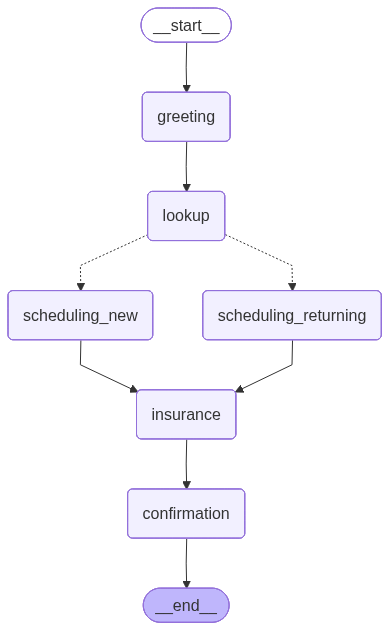

In [133]:
workflow.compile()

In [136]:
result=graph.invoke({})
result

Hello! Please provide your full name, date of birth, preferred doctor, and location.
Looking up patient Palak Bansal with DOB 2006-01-23...
No matching patient found. Proceeding as new patient.
No data fount in records, time duration for new patient: 60 minutes
Location main clinic not found for doctor Dr. Smith.
Available locations for Dr. Smith: ['Main Clinic' 'Downtown Office' 'Suburban Center']
Your details
    patient_name = Palak Bansal
    date_of_birth = 2006-01-23
    doctor = Dr. Smith
    location = main clinic
    selected_time_date = Not provided
    selected_time_end = Not provided
    selected_time_start = Not provided
    insurance_carrier = Sony
    insurance_group = grp342
    insurance_member_id = 342423
    email = paalk@gmail.com
    phone = 8810447061
    
Your details
    patient_name = Palak Bansal
    date_of_birth = 2006-01-23
    doctor = Dr. Smith
    location = main clinic
    selected_time_date = 2025-09-05
    selected_time_end = 11:30
    selected_time_s

{'patient_name': 'Palak Bansal',
 'date_of_birth': '2006-01-23',
 'doctor': 'Dr. Smith',
 'location': 'main clinic',
 'patient_type': 'new',
 'appointment_duration': '60 minutes',
 'insurance_carrier': 'Sony',
 'insurance_member_id': '342423',
 'insurance_group': 'grp342',
 'patient_email': 'paalk@gmail.com',
 'patient_contact': '8810447061',
 'appointment_confirmed': True,
 'patient_id': 51,
 'available_slots': []}